In [1]:
import MDAnalysis as mda

from rdkit.DataStructs import TanimotoSimilarity

import prolif

u = mda.Universe("unisc.parm7", "t1/1.00000000_ti.nc")

/home/sz550/miniconda3/envs/lbsr_test/lib/python3.12/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)
/home/sz550/miniconda3/envs/lbsr_test/lib/python3.12/site-packages/MDAnalysis/topology/TOPParser.py:307: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


In [2]:
prot = u.select_atoms("protein")

lig = u.select_atoms("resid 2")

fp = prolif.Fingerprint(["HBDonor", "HBAcceptor", "PiStacking"], count=True)

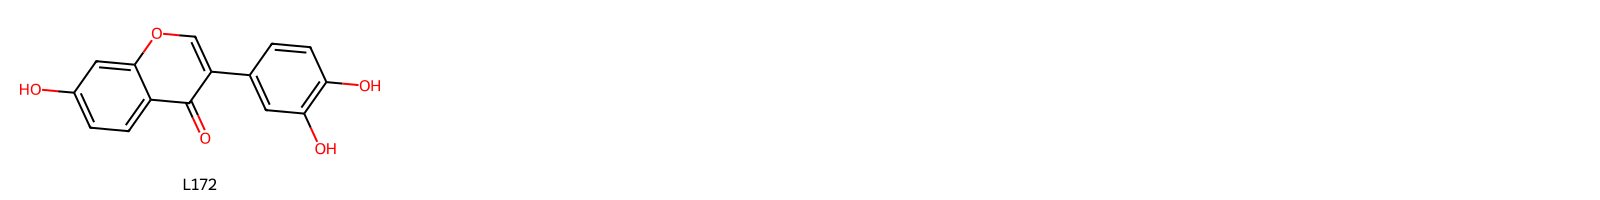

In [3]:
ligand_mol = prolif.Molecule.from_mda(lig)
# display
prolif.display_residues(ligand_mol, size=(400, 200))

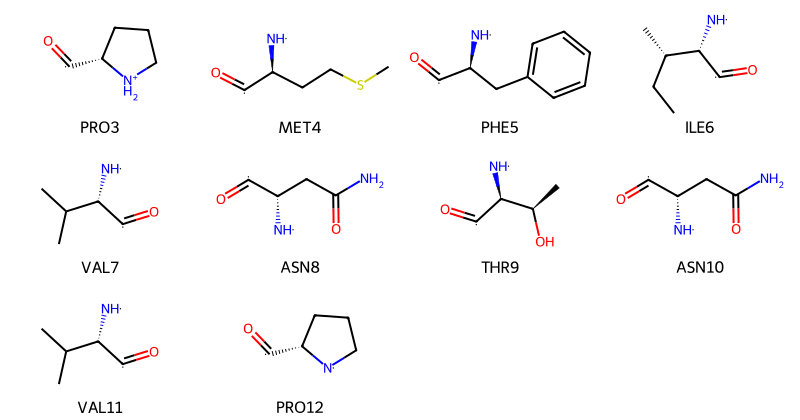

In [4]:
protein_mol = prolif.Molecule.from_mda(prot)
# remove the `slice(20)` part to show all residues
prolif.display_residues(protein_mol, slice(10))

In [5]:
fp.run(u.trajectory[1000:6001], lig, prot)

  0%|          | 0/5000 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 3 interactions: ['HBAcceptor', 'HBDonor', 'PiStacking'] at 0x7f21fc13da00>

In [6]:
fp.to_pickle("orita_13_in_t1_lam1_fingerprint.pkl")

In [7]:
df = fp.to_dataframe()

In [8]:
df

ligand            L172                                                      \
protein           PRO3       MET4      LYS34      TYR38   SER65      ILE66   
interaction HBAcceptor HBAcceptor HBAcceptor PiStacking HBDonor HBAcceptor   
Frame                                                                        
1000                 1          0          0          0       0          0   
1001                 1          0          0          1       0          1   
1002                 1          0          0          0       0          0   
1003                 1          0          0          0       0          1   
1004                 1          0          0          0       0          0   
...                ...        ...        ...        ...     ...        ...   
5995                 1          0          0          0       0          0   
5996                 1          0          0          0       0          0   
5997                 0          0          0          0       0          0   
5998                 1          0          0          0       0          0   
5999                 0          0          0          0       0          0   

ligand                                                                      \
protein                  GLY67     GLY109     TRP110     PHE115     TYR325   
interaction HBDonor HBAcceptor HBAcceptor PiStacking PiStacking PiStacking   
Frame                                                                        
1000              0          0          0          1          2          2   
1001              0          0          0          0          0          2   
1002              1          0          0          0          0          2   
1003              0          0          0          0          0          2   
1004              0          0          0          0          0          2   
...             ...        ...        ...        ...        ...        ...   
5995              0          0          0          0          1          2   
5996              0          0          0          0          1          2   
5997              0          0          0          0          1          1   
5998              0          0          0          0          1          2   
5999              0          0          0          0          0          2   

ligand                                     
protein         ILE326     ASN327          
interaction HBAcceptor HBAcceptor HBDonor  
Frame                                      
1000                 0          0       1  
1001                 0          0       1  
1002                 0          0       1  
1003                 0          0       1  
1004                 0          0       1  
...                ...        ...     ...  
5995                 0          0       1  
5996                 0          0       1  
5997                 0          0       1  
5998                 0          0       1  
5999                 0          0       1  

[5000 rows x 15 columns]

In [9]:
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand            L172                                                      \
protein         TYR325  ASN327       PRO3      ILE66     PHE115      LYS34   
interaction PiStacking HBDonor HBAcceptor HBAcceptor PiStacking HBAcceptor   
%               176.12   98.78      75.88      27.52      18.58       4.58   

ligand                                                                      \
protein       ILE66      GLY67      TYR38     TRP110     ILE326     GLY109   
interaction HBDonor HBAcceptor PiStacking PiStacking HBAcceptor HBAcceptor   
%              3.06       1.58       1.36        1.0       0.36       0.16   

ligand                                     
protein           MET4   SER65     ASN327  
interaction HBAcceptor HBDonor HBAcceptor  
%                  0.1    0.04       0.04

In [10]:
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand    L172                                                              \
protein ASN327 TYR325   PRO3  ILE66 PHE115 LYS34 GLY67 TYR38 TRP110 ILE326   
%        98.78  92.78  75.88  28.96  17.08  4.36  1.58  1.36    1.0   0.36   

ligand                     
protein GLY109 MET4 SER65  
%         0.16  0.1  0.04

In [11]:
# 10 residues most frequently interacting with the ligand
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("%")
    .T
    * 100
)

ligand    L172                                                            
protein ASN327 TYR325   PRO3  ILE66 PHE115 LYS34 GLY67 TYR38 TRP110 ILE326
%        98.78  92.78  75.88  28.96  17.08  4.36  1.58  1.36    1.0   0.36

In [12]:
# Tanimoto similarity between the first frame and the rest
from rdkit import DataStructs

bitvectors = fp.to_bitvectors()
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)
tanimoto_sims


[1.0,
 0.42857142857142855,
 0.5,
 0.5,
 0.6,
 0.2,
 0.8,
 0.6,
 0.6,
 0.4,
 0.8,
 0.42857142857142855,
 0.6,
 0.6,
 0.8,
 0.8,
 0.8,
 0.14285714285714285,
 0.6,
 0.6,
 0.2,
 0.5,
 0.2857142857142857,
 0.3333333333333333,
 0.4,
 0.6,
 0.6,
 0.8,
 0.2857142857142857,
 0.8,
 0.6,
 0.2857142857142857,
 0.6,
 0.8,
 0.4,
 0.4,
 0.5,
 0.5,
 0.4,
 0.5,
 0.8,
 0.6,
 0.4,
 0.5,
 0.6,
 0.6,
 0.5,
 0.4,
 0.3333333333333333,
 0.6,
 0.6,
 0.6,
 0.6,
 0.5,
 0.5,
 0.2,
 0.8,
 0.6,
 0.4,
 0.5,
 0.6,
 0.42857142857142855,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.16666666666666666,
 0.2,
 0.6,
 0.6,
 0.6,
 0.4,
 0.8,
 0.2,
 0.4,
 0.42857142857142855,
 0.5,
 0.6,
 0.8,
 0.5,
 0.5,
 0.5,
 0.4,
 0.6,
 0.5,
 0.4,
 0.2,
 0.4,
 0.5,
 0.4,
 0.5,
 0.6,
 0.14285714285714285,
 0.2857142857142857,
 0.42857142857142855,
 0.5,
 0.2857142857142857,
 0.6,
 0.4,
 0.4,
 0.5,
 0.6,
 0.6,
 0.4,
 0.3333333333333333,
 0.6,
 0.5,
 0.6,
 0.5,
 0.5,
 0.8,
 0.6,
 0.5,
 0.8,
 0.5,
 0.8,
 0.6,
 0.2857142857142857,
 0.6,
 0.4,
 0.5,
 0.6,

In [13]:
"""
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Tanimoto similarity matrix
bitvectors = fp.to_bitvectors()
similarity_matrix = []
for bv in bitvectors:
    similarity_matrix.append(DataStructs.BulkTanimotoSimilarity(bv, bitvectors))
similarity_matrix = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)

# display heatmap
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
colormap = sns.diverging_palette(
    300, 145, s=90, l=80, sep=30, center="dark", as_cmap=True
)
sns.heatmap(
    similarity_matrix,
    ax=ax,
    square=True,
    cmap=colormap,
    vmin=0,
    vmax=1,
    center=0.5,
    xticklabels=5,
    yticklabels=5,
)
ax.invert_yaxis()
plt.yticks(rotation="horizontal")
fig.patch.set_facecolor("white")
"""

'\nimport pandas as pd\nimport seaborn as sns\nfrom matplotlib import pyplot as plt\n\n# Tanimoto similarity matrix\nbitvectors = fp.to_bitvectors()\nsimilarity_matrix = []\nfor bv in bitvectors:\n    similarity_matrix.append(DataStructs.BulkTanimotoSimilarity(bv, bitvectors))\nsimilarity_matrix = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)\n\n# display heatmap\nfig, ax = plt.subplots(figsize=(3, 3), dpi=200)\ncolormap = sns.diverging_palette(\n    300, 145, s=90, l=80, sep=30, center="dark", as_cmap=True\n)\nsns.heatmap(\n    similarity_matrix,\n    ax=ax,\n    square=True,\n    cmap=colormap,\n    vmin=0,\n    vmax=1,\n    center=0.5,\n    xticklabels=5,\n    yticklabels=5,\n)\nax.invert_yaxis()\nplt.yticks(rotation="horizontal")\nfig.patch.set_facecolor("white")\n'

<Axes: xlabel='Frame'>

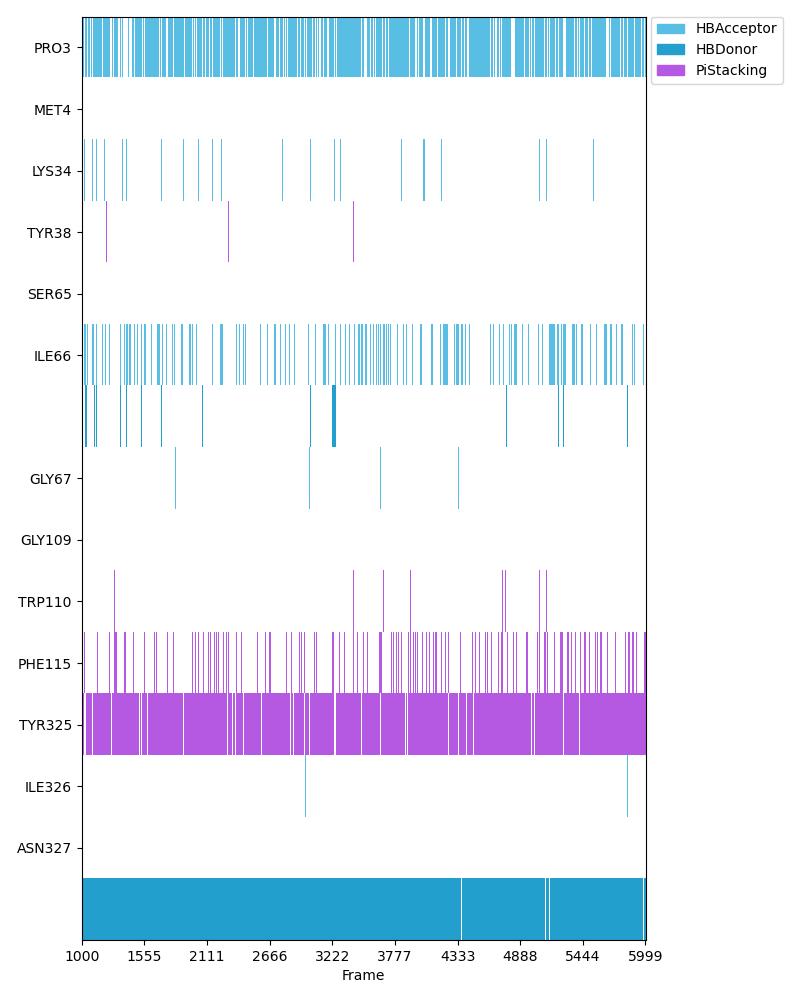

In [14]:
%matplotlib ipympl
fp.plot_barcode()

In [15]:
view = fp.plot_lignetwork(ligand_mol, threshold=0.0, display_all=True)
view

In [16]:
frame = 1001
# seek specific frame
u.trajectory[frame]
view = fp.plot_3d(ligand_mol, protein_mol, frame=frame, display_all=False)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
from prolif.plotting.complex3d import Complex3D

frame = 1001
u.trajectory[frame]
comp3D = Complex3D.from_fingerprint(fp, ligand_mol, protein_mol, frame=frame)

frame = 5800
u.trajectory[frame]
other_comp3D = Complex3D.from_fingerprint(fp, ligand_mol, protein_mol, frame=frame)

view = comp3D.compare(other_comp3D)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.